# TensorFlow 2 - USE: Movie Review Sentiment Analysis Using Universal Sentence Encoder

**Dataset**

IMDB dataset has 50K movie reviews for natural language processing.
Please download the dataset from [Kaggle link for IMDB master](https://www.kaggle.com/uttam94/imdb-mastercsv) and preprocess the data. Use the column "type" to seperate training and test datasets if needed as used in this case.

**Problem**

A review in the IMDB dataset is either positive or negative. Therefore, the NLP movie review sentiment analysis task is a supervised learning binary classification problem.

In [1]:
# Enable intellisense
%config IPCompleter.greedy=True

In [2]:
# Import modules
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import  Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tqdm import tqdm
import matplotlib.pyplot as plt


## from ssnet
from keras.layers import BatchNormalization, InputLayer, RepeatVector
from keras.layers import Dense, Activation, Dropout, Input, LSTM, Flatten

print("TensorFlow Version:",tf.__version__)
print("Hub version: ",hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
pd.set_option('display.max_colwidth',1000)

import importlib

TensorFlow Version: 2.2.0
Hub version:  0.9.0
GPU is available


In [3]:
import sys
sys.path.append("./helpers")
import imdb_preprocess_functions as imdb
dir(imdb)
sys.path.append("../model_helpers")
import model_utils as model_utils

## USE functions
sys.path.append("../use_helpers")
import use_functions as iUse

In [4]:
importlib.reload(model_utils)
importlib.reload(iUse)

<module 'use_functions' from '../use_helpers/use_functions.py'>

## Data preprocessing

In [5]:
# Load imdb master data, return 25K train and 25K test datasets
[df_train, df_test] = imdb.get_imdb_df_data('./data/imdb_master.csv')

The number of rows and columns in the training dataset is: (25000, 5)
Missing values in train dataset:
Unnamed: 0    0
type          0
review        0
label         0
file          0
dtype: int64
Check train class balance
1.0    12500
0.0    12500
Name: label, dtype: int64
The number of rows and columns in the test dataset is: (25000, 5)
Missing values in test dataset:
Unnamed: 0    0
type          0
review        0
label         0
file          0
dtype: int64
Check test class balance
1.0    12500
0.0    12500
Name: label, dtype: int64


In [6]:
# Preprocess 25K train data. Return review texts with label (positive or negative). Train data is reproducibly shuffled.
train_data = text_train, label_train, df_fit_train = imdb.get_fit_data(df_train, True)

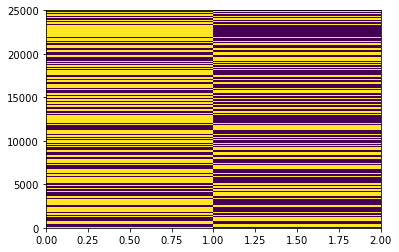

In [7]:
# Plot class districution before shuffle the training dataset
plt.pcolormesh(train_data[1])

In [8]:
# model = tf.keras.Sequential()
# #model.add(hub_layer)
# model.add(tf.keras.layers.Input(shape=(512,)))
# model.add(tf.keras.layers.Dense(16, activation='relu'))
# model.add(tf.keras.layers.Dense(2, activation="softmax", name="predictions"))

# model.summary()

# model = tf.keras.Sequential()
# model.add(hub_layer)
# model.add(
#   tf.keras.layers.Dense(
#     units=256,
#     #input_shape=(512, ),
#     activation='relu'
#   )
# )
# model.add(
#   tf.keras.layers.Dropout(rate=0.5)
# )
# model.add(
#   tf.keras.layers.Dense(
#     units=128,
#     activation='relu'
#   )
# )
# model.add(
#   tf.keras.layers.Dropout(rate=0.5)
# )
# model.add(tf.keras.layers.Dense(2, activation='softmax'))

# model.summary()
# tf.keras.utils.plot_model(model, "model_d_use.png", show_shapes=True, dpi=48)

## Define run types

In [9]:
model_utils.RunType.get_run_detail()

(('FULL', 1, 'Full run'),
 ('SPLIT',
  2,
  'Train data is split to two parts, first part is used in training, and second part is used in testing'),
 ('SHORT',
  3,
  'Short run using small number of samples to train and test to see if the work flow works correctly'))

In [10]:
# Specify run types, test run size and split training data size
RUN_TYPE = model_utils.RunType.SPLIT
TEST_RUN_SIZE = 500
SPLIT_TRAIN_SIZE = 24000

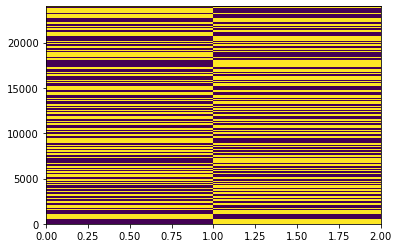

In [11]:
# Prepare model required final input and output 
train_final_data = train_data 
# split train data run
if RUN_TYPE is model_utils.RunType.SPLIT:
    train_final_data = train_data[0][:SPLIT_TRAIN_SIZE], train_data[1][:SPLIT_TRAIN_SIZE], train_data[2][:SPLIT_TRAIN_SIZE]
# test run
if RUN_TYPE == model_utils.RunType.SHORT:
    train_final_data = train_data[0][:TEST_RUN_SIZE], train_data[1][:TEST_RUN_SIZE], train_data[2][:TEST_RUN_SIZE]
    
x_train = train_final_data[0]
y_train = train_final_data[1]
plt.pcolormesh(y_train)


## Model training

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
use_hub_layer (KerasLayer)   (None, 512)               256797824 
_________________________________________________________________
input_1 (InputLayer)         multiple                  0         
_________________________________________________________________
dense (Dense)                (None, 16)                8208      
_________________________________________________________________
predictions (Dense)          (None, 2)                 34        
Total params: 256,806,066
Trainable params: 256,806,066
Non-trainable params: 0
_________________________________________________________________


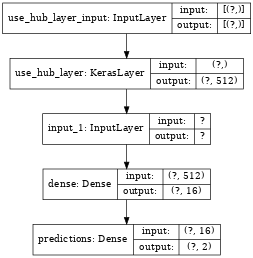

In [12]:
use_model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
#use_model_url = "https://tfhub.dev/google/universal-sentence-encoder-large/4" #This does not work well
#use_model_url = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
#hub_layer = hub.KerasLayer(use_model_url, output_shape = [512], input_shape = [], dtype = tf.string, trainable = True)
model = iUse.get_model(use_model_url, 2, 1)
model.summary()
tf.keras.utils.plot_model(model, "model_use.png", show_shapes=True, dpi=48)

In [13]:
# Model parameter set
BATCH_SIZE = 100
EPOCHS = 7
LRATE = 2e-4
LOSS = 'categorical_crossentropy'
METRICS = 'accuracy'

In [14]:
# Specify model name
root_name = 'model_use'
if RUN_TYPE is model_utils.RunType.FULL:
    model_file_name = root_name + '_25000_'
if RUN_TYPE is model_utils.RunType.SPLIT:
    model_file_name = root_name + '_' + str(SPLIT_TRAIN_SIZE) + '_'
model_name = model_file_name + 'epoch_' + str(EPOCHS) + ".h5"
if RUN_TYPE is model_utils.RunType.SHORT:
    model_name = "tmp_"+ root_name +'_'+ 'epoch_' + str(EPOCHS) + ".h5"

In [15]:
# Train the model
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

#Use Adam optimizer to minimize the categorical_crossentropy loss
opt = Adam(learning_rate=LRATE)
model.compile(optimizer=opt, 
              loss=LOSS,
              metrics=[METRICS])

Epoch 1/7
240/240 [==============================] - 35s 147ms/step - loss: 0.4702 - accuracy: 0.8079
Epoch 2/7
240/240 [==============================] - 35s 145ms/step - loss: 0.2130 - accuracy: 0.9227
Epoch 3/7
240/240 [==============================] - 35s 146ms/step - loss: 0.0736 - accuracy: 0.9801
Epoch 4/7
240/240 [==============================] - 35s 146ms/step - loss: 0.0225 - accuracy: 0.9964
Epoch 5/7
240/240 [==============================] - 35s 144ms/step - loss: 0.0096 - accuracy: 0.9986
Epoch 6/7
240/240 [==============================] - 35s 146ms/step - loss: 0.0042 - accuracy: 0.9996
Epoch 7/7
240/240 [==============================] - 35s 146ms/step - loss: 0.0026 - accuracy: 0.9998
dict_keys(['loss', 'accuracy'])


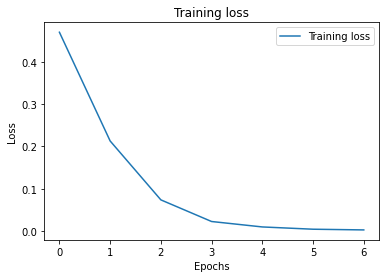

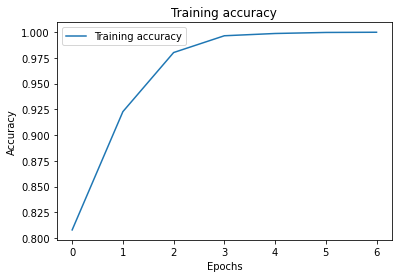

In [16]:
# Fit the data to the model
history = model.fit(x_train, y_train,
#history = model.fit(X_train, y_train,
#history = model.fit(hub_layer (train_data[0][:300]), y_train[:300],
    #validation_data=(X_test, y_test),
    #validation_split=0.2, # Important: in production, use all training data
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    #callbacks=[tensorboard_callback],
                    verbose = 1)

# Save the trained model
model.save(model_name)
model_utils.get_history(history)

In [17]:
# Load the pretrained nlp_model
from tensorflow.keras.models import load_model
new_model = load_model(model_name, custom_objects={'KerasLayer':hub.KerasLayer})

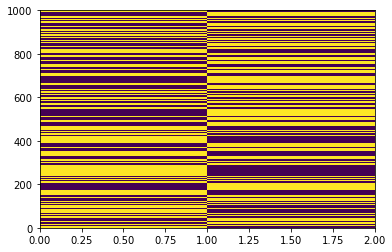

In [18]:
# Preprocess 25K test data. Return review texts with label (positive or negative). 
# Test data for full run is not shuffled. Test data for short test run is shuffled.
# For split run, use train portion of data in testing.

need_shuffle = False
if RUN_TYPE is model_utils.RunType.SHORT:
    need_shuffle = True
test_final_data = test_data = text_test, label_test, df_fit_test = imdb.get_fit_data(df_test, need_shuffle)

# split train data in test for split run
if RUN_TYPE is model_utils.RunType.SPLIT:
    test_final_data = train_data[0][SPLIT_TRAIN_SIZE:], train_data[1][SPLIT_TRAIN_SIZE:], train_data[2][SPLIT_TRAIN_SIZE:]
# get smaller data size for short test run
if RUN_TYPE is model_utils.RunType.SHORT:
    test_final_data = test_data[0][:TEST_RUN_SIZE], test_data[1][:TEST_RUN_SIZE], test_data[2][:TEST_RUN_SIZE]

x_test = test_final_data[0]
y_test = test_final_data[1]
plt.pcolormesh(y_test)


In [19]:
# Get predictions for test data
prediction_prob = model_utils.get_model_performance(model_name, x_test, y_test, BATCH_SIZE)

10/10 [==============================] - 1s 91ms/step - loss: 0.4053 - accuracy: 0.8830
[0.4052802324295044, 0.8830000162124634]


In [20]:
# Create result file
result_file_root_name = root_name + '_result'
model_utils.output_result(test_final_data[2], result_file_root_name, RUN_TYPE.value, prediction_prob, SPLIT_TRAIN_SIZE)

196/196 [==============================] - 24s 123ms/step - loss: 0.3995 - accuracy: 0.8864
[0.3994869887828827, 0.8863599896430969]


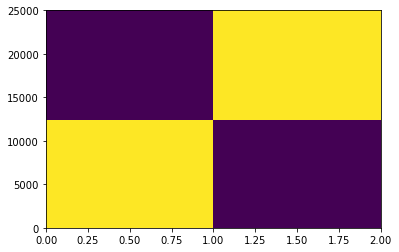

In [21]:
# Run prediction and create result file for 25k test data for split run
if RUN_TYPE is model_utils.RunType.SPLIT:
    x_test = test_data[0]
    y_test = test_data[1]
    plt.pcolormesh(y_test)
    prediction_prob = model_utils.get_model_performance(model_name, x_test, y_test, 128)
    model_utils.output_result(test_data[2], result_file_root_name, RUN_TYPE.value, prediction_prob, SPLIT_TRAIN_SIZE)